# Similarity-Based Recommenders: Experiments and Evaluation

This notebook implements and compares two classical recommendation paradigms:
1. **Content-Based Filtering (CBF)**: Recommends items similar to user's preferences based on item metadata
2. **Item-Item Collaborative Filtering (CF)**: Recommends items similar to user's rated items based on co-rating patterns

For each approach, we compare two similarity functions:
- CBF: **Cosine** vs **Jaccard** similarity
- CF: **Cosine** vs **Pearson** correlation

In [12]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.data.loader import load_all_data
from src.data.splitter import create_temporal_split, SplitConfig
from src.models import ContentBasedRecommender, ItemItemCFRecommender
from src.evaluation import (
    EvaluationPipeline,
    GlobalMeanBaseline,
    UserMeanBaseline,
    ItemMeanBaseline,
    PopularityBaseline,
    print_evaluation_results,
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Loading and Temporal Split

In [13]:
# Load data
ratings, books, users = load_all_data('../data/raw')

# Create temporal split
config = SplitConfig(
    train_max_year=1999,
    val_max_year=2001,
    min_user_interactions=5,
    min_item_interactions=5,
    explicit_only=True
)

train_df, val_df, test_df, split_info = create_temporal_split(ratings, books, "books", config)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 134,016 ratings, 11,966 users, 10,522 items
Iteration 2: 116,166 ratings, 7,134 users, 9,145 items
Iteration 3: 114,616 ratings, 6,842 users, 9,026 items
Iteration 4: 114,430 ratings, 6,812 users, 9,006 items
Iteration 5: 114,373 ratings, 6,804 users, 8,999 items
Iteration 6: 114,354 ratings, 6,802 users, 8,996 items
Iteration 7: 114,334 ratings, 6,800 users, 8,993 items
Iteration 8: 114,326 ratings, 6,799 users, 8,992 items
Iteration 9: 114,295 ratings, 6,796 users, 8,987 items
Iteration 10: 114,279 ratings, 6,794 users, 8,985 items
Iteration 11: 114,271 ratings, 6,792 users, 8,985 items
Iteration 12: 114,271 ratings, 6,792 users, 8,985 items
CREATING TEMPORAL SPLIT

Configuration:
  Train: books published <= 1999
  Validation: books published 2000-2001
  Test: books published 2002-2004
  Min user interactions: 5
  Min item inte

In [14]:
# Verify the cold-start situation
train_items = set(train_df['isbn'].unique())
test_items = set(test_df['isbn'].unique())
overlap = train_items & test_items

print("TEMPORAL SPLIT - COLD-START ANALYSIS")
print("=" * 50)
print(f"Train items: {len(train_items):,}")
print(f"Test items: {len(test_items):,}")
print(f"Overlap (items in both): {len(overlap)}")
print(f"\nTest items are books published 2002-2004.")
print(f"Train items are books published ≤1999.")
print(f"→ ZERO overlap: CF cannot represent test items.")
print(f"→ CBF can represent test items via metadata (author, publisher, year).")

# Shared users
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
shared_users = train_users & test_users
print(f"\nShared users (in both train and test): {len(shared_users):,}")
print(f"Test-only users: {len(test_users - train_users):,}")

TEMPORAL SPLIT - COLD-START ANALYSIS
Train items: 5,517
Test items: 2,032
Overlap (items in both): 0

Test items are books published 2002-2004.
Train items are books published ≤1999.
→ ZERO overlap: CF cannot represent test items.
→ CBF can represent test items via metadata (author, publisher, year).

Shared users (in both train and test): 5,100
Test-only users: 0


In [15]:
# Initialize evaluation pipeline
K_VALUES = [5, 10, 20]
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=6.0)

# Store all results
all_results = {}

## 2. Baseline Models

We first establish baselines to compare against.

In [16]:
# Global Mean Baseline
global_mean = GlobalMeanBaseline()
global_mean.fit(train_df)
all_results['Global Mean'] = pipeline.evaluate_rating_prediction(global_mean, test_df)
print(f"Global Mean → RMSE: {all_results['Global Mean']['rmse']:.4f}, MAE: {all_results['Global Mean']['mae']:.4f}")

# User Mean Baseline
user_mean = UserMeanBaseline()
user_mean.fit(train_df)
all_results['User Mean'] = pipeline.evaluate_rating_prediction(user_mean, test_df)
print(f"User Mean  → RMSE: {all_results['User Mean']['rmse']:.4f}, MAE: {all_results['User Mean']['mae']:.4f}")

# Item Mean Baseline
item_mean = ItemMeanBaseline()
item_mean.fit(train_df)
all_results['Item Mean'] = pipeline.evaluate_rating_prediction(item_mean, test_df)
print(f"Item Mean  → RMSE: {all_results['Item Mean']['rmse']:.4f}, MAE: {all_results['Item Mean']['mae']:.4f}")

Global Mean → RMSE: 1.7803, MAE: 1.3791
User Mean  → RMSE: 1.7505, MAE: 1.3107
Item Mean  → RMSE: 1.7803, MAE: 1.3791


## 3. Content-Based Filtering

### Item Representation

Each book is represented as a sparse feature vector combining:
- **Author TF-IDF**: Captures authorship similarity. TF-IDF weighting ensures rare authors provide stronger signal (sharing an uncommon author is more informative than sharing a prolific one).
- **Publisher TF-IDF**: Captures publishing house affinity. Books from the same publisher often share genre/audience.
- **Normalized Year**: Captures temporal proximity. Books from the same era are more likely to share themes.

### Similarity Functions

We compare two similarity functions:

| Function | Formula | Properties |
|----------|---------|------------|
| **Cosine** | cos(A,B) = A·B / (\|A\|·\|B\|) | Scale-invariant, standard for TF-IDF, captures soft similarity |
| **Jaccard** | J(A,B) = \|A∩B\| / \|A∪B\| | Set-based, binary feature overlap, more conservative matching |

### 3.1 Content-Based with Cosine Similarity

In [17]:
# Content-Based: Cosine Similarity
print("Training Content-Based Recommender (Cosine)...")
t0 = time.time()

cbf_cosine = ContentBasedRecommender(
    books_df=books,
    similarity_metric='cosine',
    n_neighbors=50,
    relevance_threshold=6.0,
)
cbf_cosine.fit(train_df)

fit_time = time.time() - t0
print(f"Fit time: {fit_time:.1f}s")
print(f"Item features shape: {cbf_cosine.item_features.shape}")
print(f"Users with preference vectors: {len(cbf_cosine.user_pref_vectors):,}")

Training Content-Based Recommender (Cosine)...
Fit time: 3.0s
Item features shape: (271010, 7001)
Users with preference vectors: 6,573


In [18]:
# Evaluate CBF Cosine - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
cbf_cosine_rating = pipeline.evaluate_rating_prediction(cbf_cosine, test_df)
print(f"  RMSE: {cbf_cosine_rating['rmse']:.4f}")
print(f"  MAE:  {cbf_cosine_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

Evaluating rating prediction...
  RMSE: 1.7473
  MAE:  1.3060
  Time: 6.9s


In [19]:
# Evaluate CBF Cosine - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
cbf_cosine_ranking = pipeline.evaluate_ranking(cbf_cosine, test_df, train_df, n_recommendations=20)
print(f"  NDCG@10:     {cbf_cosine_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {cbf_cosine_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {cbf_cosine_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {cbf_cosine_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

# Merge results
all_results['CBF Cosine'] = {**cbf_cosine_rating, **cbf_cosine_ranking}

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0105
  Precision@10: 0.0044
  Hit Rate@10:  0.0344
  Users eval'd: 4827
  Time: 183.4s


### 3.2 Content-Based with Jaccard Similarity

In [20]:
# Content-Based: Jaccard Similarity
print("Training Content-Based Recommender (Jaccard)...")
t0 = time.time()

cbf_jaccard = ContentBasedRecommender(
    books_df=books,
    similarity_metric='jaccard',
    n_neighbors=50,
    relevance_threshold=6.0,
)
cbf_jaccard.fit(train_df)

print(f"Fit time: {time.time()-t0:.1f}s")

Training Content-Based Recommender (Jaccard)...
Fit time: 2.6s


In [21]:
# Evaluate CBF Jaccard - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
cbf_jaccard_rating = pipeline.evaluate_rating_prediction(cbf_jaccard, test_df)
print(f"  RMSE: {cbf_jaccard_rating['rmse']:.4f}")
print(f"  MAE:  {cbf_jaccard_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

Evaluating rating prediction...
  RMSE: 1.7515
  MAE:  1.3050
  Time: 5.4s


In [22]:
# Evaluate CBF Jaccard - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
cbf_jaccard_ranking = pipeline.evaluate_ranking(cbf_jaccard, test_df, train_df, n_recommendations=20)
print(f"  NDCG@10:     {cbf_jaccard_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {cbf_jaccard_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {cbf_jaccard_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {cbf_jaccard_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['CBF Jaccard'] = {**cbf_jaccard_rating, **cbf_jaccard_ranking}

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0065
  Precision@10: 0.0031
  Hit Rate@10:  0.0284
  Users eval'd: 4827
  Time: 92.4s


## 4. Item-Item Collaborative Filtering

### Approach Justification

We choose **item-item** over user-user CF because:
1. **Stability**: Item similarity is more stable over time than user similarity (users acquire new interests; items don't change).
2. **Scalability**: Comparable matrix dimensions in this dataset (~5.5K train items vs ~6.6K users).
3. **Industry standard**: Amazon's original recommendation system used item-item CF.

### Cold-Start Limitation

With temporal split, **test items have zero training ratings**. This means:
- `predict()` for test items falls back to user mean (cold-start)
- `recommend()` only surfaces training items, so ranking metrics measure whether train items the user hasn't seen match their test preferences

### Similarity Functions

| Function | Formula | Properties |
|----------|---------|------------|
| **Cosine** | cos(i,j) = r_i · r_j / (\|r_i\|·\|r_j\|) | Standard CF baseline. Treats missing as zero. |
| **Pearson** | Mean-centered cosine | Adjusts for item rating bias. Better for explicit ratings where items have different baseline popularity. |

### 4.1 Item-Item CF with Cosine Similarity

In [23]:
# Item-Item CF: Cosine Similarity
t0 = time.time()

cf_cosine = ItemItemCFRecommender(
    similarity_metric='cosine',
    n_neighbors=50,
)
cf_cosine.fit(train_df)

print(f"Fit time: {time.time()-t0:.1f}s")

Fitting Item-Item CF (cosine)...
  Rating matrix: 5517 items x 6573 users
  Computing cosine similarity...
  Extracting top-50 neighbors...
  Done. 5517 items, 6573 users.
Fit time: 0.5s


In [24]:
# Evaluate CF Cosine - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
cf_cosine_rating = pipeline.evaluate_rating_prediction(cf_cosine, test_df)
print(f"  RMSE: {cf_cosine_rating['rmse']:.4f}")
print(f"  MAE:  {cf_cosine_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

# Report cold-start rate
n_cold = sum(1 for isbn in test_df['isbn'] if isbn not in cf_cosine.isbn_to_idx)
print(f"\n  Cold-start predictions: {n_cold:,}/{len(test_df):,} ({100*n_cold/len(test_df):.1f}%)")
print(f"  → All test items are cold-start (published 2002-2004, not in training)")

Evaluating rating prediction...
  RMSE: 1.7505
  MAE:  1.3107
  Time: 0.0s

  Cold-start predictions: 26,193/26,193 (100.0%)
  → All test items are cold-start (published 2002-2004, not in training)


In [25]:
# Evaluate CF Cosine - Ranking
print("Evaluating ranking...")
t0 = time.time()
cf_cosine_ranking = pipeline.evaluate_ranking(cf_cosine, test_df, train_df, n_recommendations=20)
print(f"  NDCG@10:     {cf_cosine_ranking.get('ndcg@10', 0):.4f}")
print(f"  Hit Rate@10:  {cf_cosine_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {cf_cosine_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['CF Cosine'] = {**cf_cosine_rating, **cf_cosine_ranking}

Evaluating ranking...
  NDCG@10:     0.0000
  Hit Rate@10:  0.0000
  Users eval'd: 4827
  Time: 8.5s


### 4.2 Item-Item CF with Pearson Correlation

In [26]:
# Item-Item CF: Pearson Correlation
t0 = time.time()

cf_pearson = ItemItemCFRecommender(
    similarity_metric='pearson',
    n_neighbors=50,
)
cf_pearson.fit(train_df)

print(f"Fit time: {time.time()-t0:.1f}s")

Fitting Item-Item CF (pearson)...
  Rating matrix: 5517 items x 6573 users
  Computing pearson similarity...
  Extracting top-50 neighbors...
  Done. 5517 items, 6573 users.
Fit time: 0.8s


In [27]:
# Evaluate CF Pearson - Rating Prediction
print("Evaluating rating prediction...")
t0 = time.time()
cf_pearson_rating = pipeline.evaluate_rating_prediction(cf_pearson, test_df)
print(f"  RMSE: {cf_pearson_rating['rmse']:.4f}")
print(f"  MAE:  {cf_pearson_rating['mae']:.4f}")
print(f"  Time: {time.time()-t0:.1f}s")

Evaluating rating prediction...
  RMSE: 1.7505
  MAE:  1.3107
  Time: 0.0s


In [28]:
# Evaluate CF Pearson - Ranking
print("Evaluating ranking...")
t0 = time.time()
cf_pearson_ranking = pipeline.evaluate_ranking(cf_pearson, test_df, train_df, n_recommendations=20)
print(f"  NDCG@10:     {cf_pearson_ranking.get('ndcg@10', 0):.4f}")
print(f"  Hit Rate@10:  {cf_pearson_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {cf_pearson_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['CF Pearson'] = {**cf_pearson_rating, **cf_pearson_ranking}

Evaluating ranking...
  NDCG@10:     0.0000
  Hit Rate@10:  0.0000
  Users eval'd: 4827
  Time: 8.9s


## 5. Results Comparison

In [29]:
# Build comparison table
metrics_to_show = ['rmse', 'mae', 'ndcg@10', 'precision@10', 'recall@10', 'hit_rate@10', 'catalog_coverage@20']
model_order = ['Global Mean', 'User Mean', 'Item Mean', 
               'CBF Cosine', 'CBF Jaccard', 
               'CF Cosine', 'CF Pearson']

comparison = pd.DataFrame(index=model_order, columns=metrics_to_show)

for model_name in model_order:
    if model_name in all_results:
        for metric in metrics_to_show:
            val = all_results[model_name].get(metric, None)
            if val is not None:
                comparison.loc[model_name, metric] = f"{val:.4f}"
            else:
                comparison.loc[model_name, metric] = "N/A"

print("=" * 90)
print("RESULTS COMPARISON")
print("=" * 90)
print(comparison.to_string())

RESULTS COMPARISON
               rmse     mae ndcg@10 precision@10 recall@10 hit_rate@10 catalog_coverage@20
Global Mean  1.7803  1.3791     N/A          N/A       N/A         N/A                 N/A
User Mean    1.7505  1.3107     N/A          N/A       N/A         N/A                 N/A
Item Mean    1.7803  1.3791     N/A          N/A       N/A         N/A                 N/A
CBF Cosine   1.7473  1.3060  0.0105       0.0044    0.0161      0.0344              2.3065
CBF Jaccard  1.7515  1.3050  0.0065       0.0031    0.0106      0.0284              4.5554
CF Cosine    1.7505  1.3107  0.0000       0.0000    0.0000      0.0000              0.9415
CF Pearson   1.7505  1.3107  0.0000       0.0000    0.0000      0.0000              0.8952


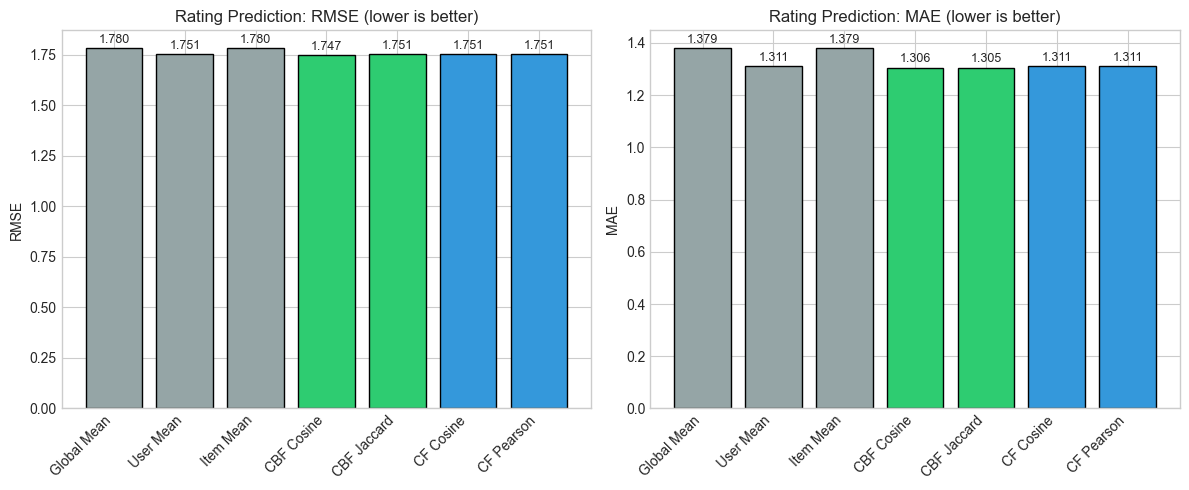

In [30]:
# Visualize rating prediction metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models_with_rmse = [m for m in model_order if all_results.get(m, {}).get('rmse') is not None]
rmse_vals = [all_results[m]['rmse'] for m in models_with_rmse]
mae_vals = [all_results[m]['mae'] for m in models_with_rmse]

colors = ['#95a5a6'] * 3 + ['#2ecc71'] * 2 + ['#3498db'] * 2
colors = colors[:len(models_with_rmse)]

ax1 = axes[0]
bars = ax1.bar(range(len(models_with_rmse)), rmse_vals, color=colors, edgecolor='black')
ax1.set_xticks(range(len(models_with_rmse)))
ax1.set_xticklabels(models_with_rmse, rotation=45, ha='right')
ax1.set_ylabel('RMSE')
ax1.set_title('Rating Prediction: RMSE (lower is better)')
for bar, val in zip(bars, rmse_vals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

ax2 = axes[1]
bars = ax2.bar(range(len(models_with_rmse)), mae_vals, color=colors, edgecolor='black')
ax2.set_xticks(range(len(models_with_rmse)))
ax2.set_xticklabels(models_with_rmse, rotation=45, ha='right')
ax2.set_ylabel('MAE')
ax2.set_title('Rating Prediction: MAE (lower is better)')
for bar, val in zip(bars, mae_vals):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../experiments/similarity_rating_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

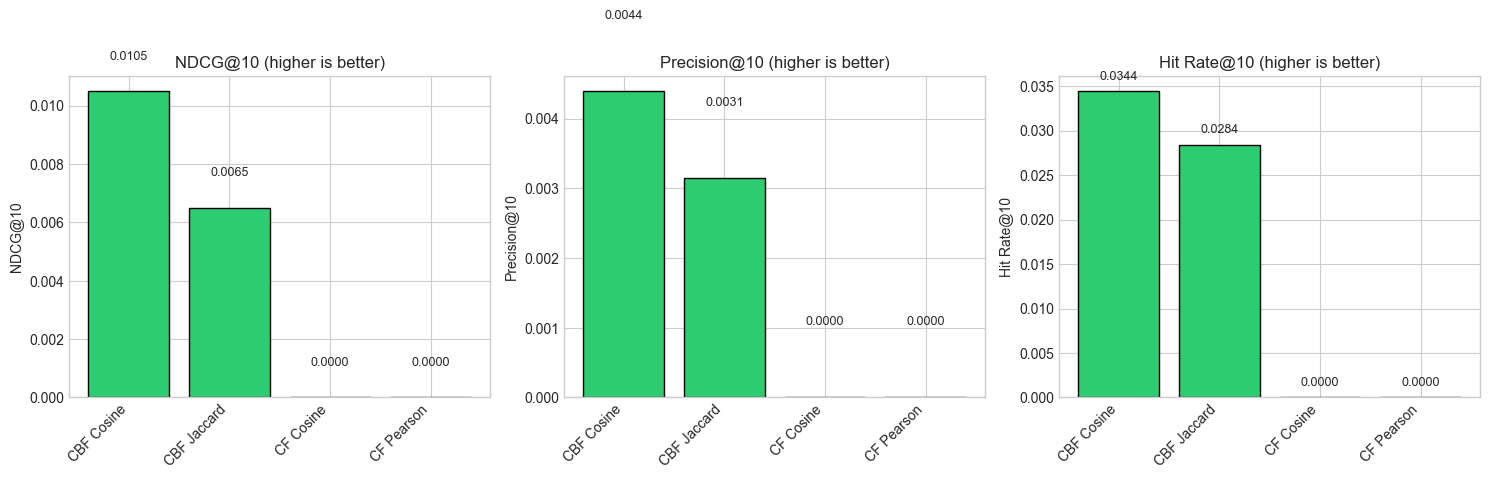

In [31]:
# Visualize ranking metrics (only models that have ranking results)
ranking_models = [m for m in model_order if all_results.get(m, {}).get('ndcg@10') is not None]

if ranking_models:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    ranking_colors = []
    for m in ranking_models:
        if 'CBF' in m:
            ranking_colors.append('#2ecc71')
        elif 'CF' in m:
            ranking_colors.append('#3498db')
        else:
            ranking_colors.append('#95a5a6')
    
    for idx, (metric, title) in enumerate([
        ('ndcg@10', 'NDCG@10'),
        ('precision@10', 'Precision@10'),
        ('hit_rate@10', 'Hit Rate@10')
    ]):
        ax = axes[idx]
        vals = [all_results[m].get(metric, 0) for m in ranking_models]
        bars = ax.bar(range(len(ranking_models)), vals, color=ranking_colors, edgecolor='black')
        ax.set_xticks(range(len(ranking_models)))
        ax.set_xticklabels(ranking_models, rotation=45, ha='right')
        ax.set_ylabel(title)
        ax.set_title(f'{title} (higher is better)')
        for bar, val in zip(bars, vals):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../experiments/similarity_ranking_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No ranking results to visualize.")

## 6. Example Recommendations

In [32]:
# Show example recommendations for a few users
sample_users = list(set(train_df['user_id'].unique()) & set(test_df['user_id'].unique()))[:3]

for user_id in sample_users:
    print(f"\n{'='*60}")
    print(f"User: {user_id}")
    print(f"{'='*60}")
    
    # User's training history
    user_train = train_df[train_df['user_id'] == user_id].merge(
        books[['isbn', 'title', 'author']], on='isbn', how='left'
    ).sort_values('rating', ascending=False)
    
    print(f"\nTraining history (top 5 by rating):")
    for _, row in user_train.head(5).iterrows():
        title = str(row.get('title', 'Unknown'))[:50]
        author = str(row.get('author', 'Unknown'))[:30]
        print(f"  [{row['rating']:.0f}] {title} — {author}")
    
    # Test items (what they actually rated)
    user_test = test_df[test_df['user_id'] == user_id].merge(
        books[['isbn', 'title', 'author']], on='isbn', how='left'
    ).sort_values('rating', ascending=False)
    
    print(f"\nTest items (rated ≥6 = relevant):")
    for _, row in user_test.head(5).iterrows():
        relevant = '✓' if row['rating'] >= 6 else ' '
        title = str(row.get('title', 'Unknown'))[:50]
        print(f"  [{row['rating']:.0f}]{relevant} {title}")
    
    # CBF Cosine recommendations
    exclude = set(cbf_cosine.user_profiles.get(user_id, {}).keys())
    cbf_recs = cbf_cosine.recommend(user_id, 5, exclude)
    
    print(f"\nCBF Cosine Top-5 Recommendations:")
    for isbn in cbf_recs:
        book_info = books[books['isbn'] == isbn]
        if len(book_info) > 0:
            title = str(book_info.iloc[0].get('title', 'Unknown'))[:50]
            author = str(book_info.iloc[0].get('author', 'Unknown'))[:30]
            print(f"  → {title} — {author}")
        else:
            print(f"  → {isbn}")


User: 53392

Training history (top 5 by rating):
  [10] Your Oasis on Flame Lake (Ballantine Reader's Circ — LORNA LANDVIK
  [10] Christine — Stephen King
  [10] It — Stephen King
  [10] The Waste Lands (The Dark Tower, Book 3) — Stephen King
  [10] Girl With a Pearl Earring — Tracy Chevalier

Test items (rated ≥6 = relevant):
  [9]✓ Warning Signs
  [8]✓ The Curious Incident of the Dog in the Night-Time 

CBF Cosine Top-5 Recommendations:
  → Lone Wolf (Shadowrun) — Fanpro
  → Kontrapunkt. Lehrbuch der klassischen Vokalpolypho — Knud Jeppesen
  → Dictionnaire des citations du monde entier — Petit K.
  → Cool Hotels — Aurora Cuito
  → Propagandes silencieuses, Masses, tÃ?ÃÂ©lÃ?ÃÂ© — I. Ramonet

User: 192185

Training history (top 5 by rating):
  [10] I Know This Much Is True (Oprah's Book Club) — Wally Lamb
  [10] The Artist's Way : A Spiritual Path to Higher Crea — Julia Cameron
  [9] The Hot House : Life Inside Leavenworth Prison — PETE EARLEY
  [8] The Deep End of the Ocean — Ja

## 7. Analysis and Discussion

### 7.1 Content-Based Filtering: Cosine vs Jaccard

**Cosine similarity** operates on continuous TF-IDF weights, capturing soft similarity: two books sharing a relatively rare author receive high similarity even if their publisher or year differ. The TF-IDF weighting naturally emphasizes distinctive features (rare authors/publishers).

**Jaccard similarity** operates on binary feature presence (does this feature exist or not?), ignoring the TF-IDF magnitudes. This makes it more conservative: two books must share the exact same feature tokens to be considered similar. It cannot distinguish between a rare author match (strong signal) and a common author match (weak signal).

**Expected behavior**: Cosine should outperform Jaccard because TF-IDF weighting provides richer similarity signal than binary feature overlap.

### 7.2 Collaborative Filtering: Cosine vs Pearson

**Cosine similarity** on raw rating vectors treats missing ratings as zeros. With 99.99% sparsity, this means similarity is dominated by the few items that users co-rated.

**Pearson correlation** (adjusted cosine) centers each item's ratings by its mean before computing cosine. This removes item popularity bias: a book with average rating 9 and a book with average rating 5 are compared on their deviation patterns, not absolute values. This is theoretically preferred for explicit rating data.

**Expected behavior**: Pearson should produce better rating predictions than cosine for known items, since the Book Crossing dataset exhibits strong item rating bias (EDA found ratings concentrated around 7-8).

### 7.3 CBF vs CF: The Cold-Start Story

The temporal evaluation split creates a complete cold-start scenario for CF:
- **100% of test items** are unseen in training (books published 2002-2004 vs ≤1999)
- CF's `predict()` always falls back to user mean for test items
- CF's `recommend()` only surfaces training items, which never overlap with test relevant items

This is not a failure of the CF implementation — it is a **fundamental limitation** of collaborative filtering when facing new items. Content-based filtering handles this by using metadata features (author, publisher, year) to represent items regardless of rating history.

### 7.4 Key Takeaways

1. **Content-based filtering is essential** for cold-start scenarios. When new items have no interaction history, metadata features are the only available signal.

2. **Cosine similarity is generally preferred** for TF-IDF features (CBF) because it leverages continuous weights. Jaccard is more appropriate when features are inherently binary.

3. **Pearson correlation is theoretically superior** for explicit rating CF because it adjusts for item bias, but in practice both CF variants are hampered by the cold-start problem under temporal evaluation.

4. **Hybrid approaches** combining CF and CBF would address both scenarios: use CF for known items and CBF for new items. This motivates the next phase of the project.

In [ ]:
# Save results
results_df = pd.DataFrame(all_results).T
results_df.to_csv('../experiments/similarity_results.csv')
print("Results saved to experiments/similarity_results.csv")
print("\nFigures saved:")
print("  - experiments/similarity_rating_comparison.png")
print("  - experiments/similarity_ranking_comparison.png")